MultiRAT analysis code
================
Joanes Grandjean

![rat art](../assets/img/rat_art.png)

# Foreword

This is a jupyter notebook which contains all the code for reproducing my
analysis. The code is meant to be followed step-wise. 

If re-using some of the scripts, please follow citations guidelines for
the software used. I’ve provided the links to the software wherever
possible. See also the [license](../LICENSE.md) for this software.


In [1]:
# init variables
init_folder='/home/traaffneu/joagra/code/MultiRat'
analysis_folder='/project/4180000.19/multiRat'
df_path='../assets/table/standardRat_20220408.tsv'

In [2]:
import os
import glob
import pandas as pd
import numpy as np

df = pd.read_csv(df_path, sep='\t')

#df = df.drop(columns=['Site'])
df['Field_strength'] = pd.Categorical(df.Field_strength)

#split breathing to only keep first value representing breathing rate at onset of scan. 
df['Breathing_onset'] = df['Breathing'].str.split('/',expand=True).iloc[:, 0]
df['Breathing_onset'] = pd.to_numeric(df['Breathing_onset'], errors='coerce')


#split temp to only keep first value representing temp at onset of scan. 
df['Temperature_onset'] = df['Temperature'].str.split('/',expand=True).iloc[:, 0]
df['Temperature_onset'] = pd.to_numeric(df['Temperature_onset'], errors='coerce')

First, let's plot some summary about the standardRat dataset. Same as for multiRat. 

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'weight [grams]')]

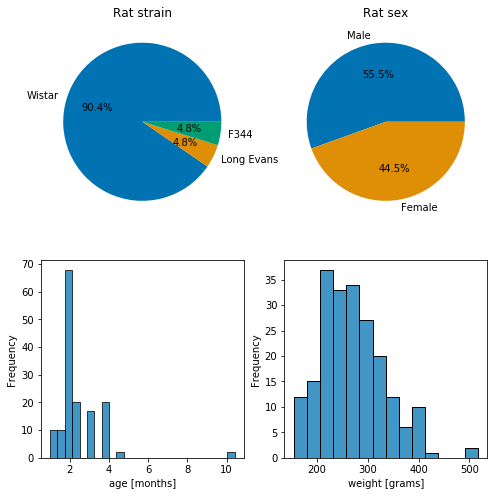

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))



ax1 = df['Sex'].value_counts().plot.pie(title='Rat sex',ax=axes[0,1],autopct="%.1f%%")
ax2 = df['Strain'].value_counts().plot.pie(title='Rat strain',ax=axes[0,0],autopct="%.1f%%")
ax3 = sns.histplot(data=df, x="Age",ax=axes[1,0])
ax4 = sns.histplot(data=df, x="Weight",ax=axes[1,1])

ax1.set(xlabel="", ylabel="")
ax2.set(xlabel="", ylabel="")
ax3.set(xlabel="age [months]", ylabel="Frequency")
ax4.set(xlabel="weight [grams]", ylabel="Frequency")

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Breathing rate [bpm]')]

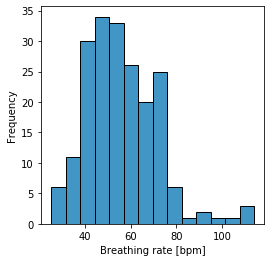

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4))




ax3 = sns.histplot(data=df, x="Breathing_onset")


ax3.set(xlabel="Breathing rate [bpm]", ylabel="Frequency")


[Text(0, 0.5, ''), Text(0.5, 0, '')]

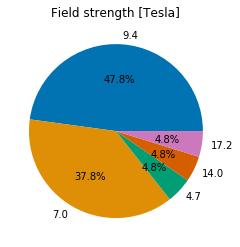

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4))

sns.set_palette("colorblind")

ax1 = df['Field_strength'].value_counts().plot.pie(title='Field strength [Tesla]', autopct="%.1f%%")

ax1.set(xlabel="", ylabel="")


Now let's examine tSNR and motion parameters

In [6]:
tsnr_map_path = os.path.join(analysis_folder, 'export_std', 'snr', 'tsnr')
tsnr_map = os.listdir(tsnr_map_path)

roiL = 520  # left barrel field cortex
roiR = 521  # right barrel field cortex


df["tsnr.S1"] = np.nan

# read the tSNR file output from RABIES and put them in the correct rows
for i in tsnr_map:
    tnsr_list = pd.read_csv(os.path.join(tsnr_map_path, i),
                            delim_whitespace=True, header=None)
    tsnr_mean = np.mean([tnsr_list[roiL], tnsr_list[roiR]])
    sub=i.split('_')[7]
    df.loc[df['SubjID'] == sub, ['tsnr.S1']]=np.double(tsnr_mean)

# let's do the same for subcortical ROIs
roiL = 731  # Striatum-L
roiR = 732  # Striatum-R

df["tsnr.str"] = np.nan
for i in tsnr_map:
    tnsr_list = pd.read_csv(os.path.join(tsnr_map_path, i),
                            delim_whitespace=True, header=None)
    tsnr_mean = np.mean([tnsr_list[roiL], tnsr_list[roiR]])
    sub=i.split('_')[7]
    df.loc[df['SubjID'] == sub, ['tsnr.str']]=np.double(tsnr_mean)

In [7]:
# then we extract the mean and max framewise displacement
MFW_map_path = os.path.join(analysis_folder, 'export_std', 'motion', 'FD')
MFW_map = os.listdir(MFW_map_path)

df["MFW"] = np.nan
df["maxFW"] = np.nan
for i in MFW_map:
    MFW_list = pd.read_csv(os.path.join(MFW_map_path, i),
                            delim_whitespace=False)
    MFW_mean = np.mean(MFW_list['Mean'])
    MFW_max = np.max(MFW_list['Mean'])
    sub=i.split('_')[0]
    df.loc[df['SubjID'] == sub, ['MFW']]=np.double(MFW_mean)
    df.loc[df['SubjID'] == sub, ['maxFW']]=np.double(MFW_max)

In [8]:
df.to_csv(df_path, sep='\t', index=False)

In [9]:
#remove excluded scans
df_exclude = df.loc[(df['exclude'] != 'yes')]

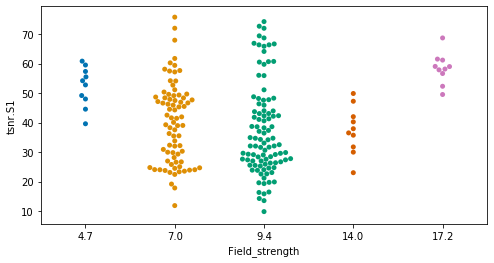

In [10]:
# plot S1 tSNR as a function of acquisition parameters

import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))

sns.set_palette("colorblind")


ax1 = sns.swarmplot(data=df_exclude, x="Field_strength", y="tsnr.S1")


correlation between tSNR in cortex and striatum
0.7655951719107429


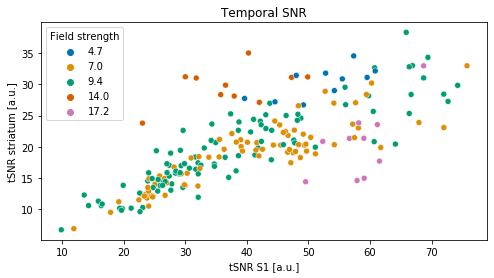

In [11]:
# does tSNR in the cortex correlate to tSNR in the striatum?
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))

sns.set_palette("colorblind")
print('correlation between tSNR in cortex and striatum')
print(df_exclude[['tsnr.S1','tsnr.str']].corr().iloc[0,1])

ax1 = sns.scatterplot(data=df_exclude, x="tsnr.S1",
                    y="tsnr.str", hue="Field_strength")

ax1.set(xlabel='tSNR S1 [a.u.]', ylabel='tSNR striatum [a.u.]', title='Temporal SNR')
ax1.get_legend().set_title('Field strength')

correlation between MFW and breathing
-0.0968733837890263


[Text(0, 0.5, 'Breathing rate [bpm]'),
 Text(0.5, 0, 'Mean framewise dispalcement [a.u.]'),
 Text(0.5, 1.0, '')]

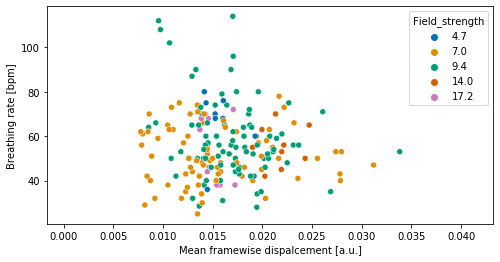

In [12]:
# does MFW correlate to breathing rate?
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))

sns.set_palette("colorblind")
print('correlation between MFW and breathing')
print(df_exclude[['MFW','Breathing_onset']].corr().iloc[0,1])

ax1 = sns.scatterplot(data=df_exclude, x="MFW",
                    y="Breathing_onset", hue="Field_strength")

ax1.set(xlabel='Mean framewise dispalcement [a.u.]', ylabel='Breathing rate [bpm]', title='')


correlation between Max_FW and breathing
0.06513724598277876


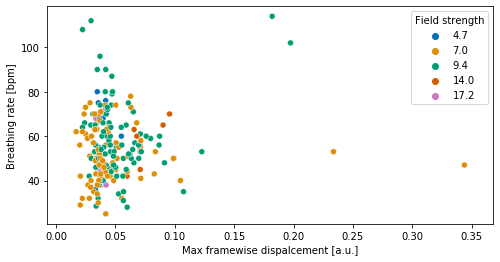

In [13]:
# does MaxFW correlate to breathing rate?
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))

sns.set_palette("colorblind")
print('correlation between Max_FW and breathing')
print(df_exclude[['maxFW','Breathing_onset']].corr().iloc[0,1])

ax1 = sns.scatterplot(data=df_exclude, x="maxFW",
                    y="Breathing_onset", hue="Field_strength")

ax1.set(xlabel='Max framewise dispalcement [a.u.]', ylabel='Breathing rate [bpm]', title='')
ax1.get_legend().set_title('Field strength')

[Text(0, 0.5, 'mean framewise displacement [a.u.]'),
 Text(0.5, 0, 'Strain'),
 Text(0.5, 1.0, 'Motion')]

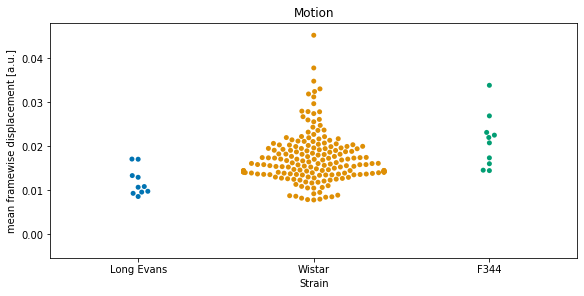

In [14]:
# plot mean framewise displacement as a function of acquisition parameters

import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4),constrained_layout=True)

sns.set_palette("colorblind")


ax1 = sns.swarmplot(data=df_exclude, x="Strain",
                    y="MFW")



ax1.set(xlabel='Strain', ylabel='mean framewise displacement [a.u.]', title='Motion')


# Functional MRI analysis
Finally!!!

In [15]:
# create empty columns for the different SBA parameters.
df['aromas_CPu_CPu'] = np.nan
df['aromas_MOp_MOp'] = np.nan
df['aromas_S1bf_S1bf'] = np.nan
df['aromas_S1bf_ACA'] = np.nan
df['aromas_S1bf_cat'] = np.nan

df['aromal_CPu_CPu'] = np.nan
df['aromal_MOp_MOp'] = np.nan
df['aromal_S1bf_S1bf'] = np.nan
df['aromal_S1bf_ACA'] = np.nan
df['aromal_S1bf_cat'] = np.nan

df['aromasr_CPu_CPu'] = np.nan
df['aromasr_MOp_MOp'] = np.nan
df['aromasr_S1bf_S1bf'] = np.nan
df['aromasr_S1bf_ACA'] = np.nan
df['aromasr_S1bf_cat'] = np.nan

df['WMCSFs_CPu_CPu'] = np.nan
df['WMCSFs_MOp_MOp'] = np.nan
df['WMCSFs_S1bf_S1bf'] = np.nan
df['WMCSFs_S1bf_ACA'] = np.nan
df['WMCSFs_S1bf_cat'] = np.nan

df['GSRs_CPu_CPu'] = np.nan
df['GSRs_MOp_MOp'] = np.nan
df['GSRs_S1bf_S1bf'] = np.nan
df['GSRs_S1bf_ACA'] = np.nan
df['GSRs_S1bf_cat'] = np.nan

In [15]:
roi_list = glob.glob((os.path.join(analysis_folder, 'template', 'roi'))+'/*')
seed_list = glob.glob((os.path.join(analysis_folder, 'export_std', 'seed','*'))+'/*')

In [17]:
import pandas as pd
pd.options.mode.chained_assignment = None

from nilearn.input_data import NiftiMasker
import re
import numpy as np

for i_orig in seed_list:
    #print(i_orig)
    i=i_orig.replace('_RAS','')
    i=i.replace('_aroma','')
    i=i.replace('_ses-1','')
    sub=os.path.basename(i).split('_')[0]
    denoise=i.split('/')[6]
    seed=os.path.basename(i).split('_')[5]
    if(seed =='ACA'):
        continue
    elif(seed =='S1bf'):
        roi='ACA'
        fc_orig=df[(denoise+'_'+seed+'_'+roi)][df['SubjID']==sub]
        fc_nan = np.isnan(fc_orig).all()
        if(fc_nan):
            r = re.compile('ACA'+'_l')
            nifti_mask=list(filter(r.findall, roi_list))[0]
            fc=NiftiMasker(nifti_mask).fit_transform(i_orig).mean()
            df[(denoise+'_'+seed+'_'+roi)][df['SubjID']==sub]=fc
    
    roi=seed
    fc_orig=df[(denoise+'_'+seed+'_'+roi)][df['SubjID']==sub]
    fc_nan = np.isnan(fc_orig).all()
    if(fc_nan):
        r = re.compile(seed+'_r')
        nifti_mask=list(filter(r.findall, roi_list))[0]
        fc=NiftiMasker(nifti_mask).fit_transform(i_orig).mean()
        df[(denoise+'_'+seed+'_'+roi)][df['SubjID']==sub]=fc
    
df.to_csv(df_path, sep='\t', index=False)

In [16]:

df_exclude = df.loc[(df['exclude'] != 'yes')]


print('missing aromas')
print(df_exclude[np.isnan(df['aromas_S1bf_S1bf']) | np.isnan(df['aromas_S1bf_ACA']) | np.isnan(df['aromas_MOp_MOp'])  | np.isnan(df['aromas_CPu_CPu'])]['SubjID'].unique())

print('missing aromal')
print(df_exclude[np.isnan(df['aromal_S1bf_S1bf']) | np.isnan(df['aromal_S1bf_ACA']) | np.isnan(df['aromal_MOp_MOp'])  | np.isnan(df['aromal_CPu_CPu'])]['SubjID'].unique())

print('missing aromasr')
print(df_exclude[np.isnan(df['aromasr_S1bf_S1bf']) | np.isnan(df['aromasr_S1bf_ACA']) | np.isnan(df['aromasr_MOp_MOp'])  | np.isnan(df['aromasr_CPu_CPu'])]['SubjID'].unique())

print('missing WMCSFs')
print(df_exclude[np.isnan(df['WMCSFs_S1bf_S1bf']) | np.isnan(df['WMCSFs_S1bf_ACA']) | np.isnan(df['WMCSFs_MOp_MOp'])  | np.isnan(df['WMCSFs_CPu_CPu'])]['SubjID'].unique())

print('missing GSRs')
print(df_exclude[np.isnan(df['GSRs_S1bf_S1bf']) | np.isnan(df['GSRs_S1bf_ACA']) | np.isnan(df['GSRs_MOp_MOp'])  | np.isnan(df['GSRs_CPu_CPu'])]['SubjID'].unique())


missing aromas
[]
missing aromal
[]
missing aromasr
[]
missing WMCSFs
[]
missing GSRs
[]


In [17]:
# This is a function to estimate functional connectivity specificity. See Grandjean 2020 for details on the reasoning 

def specific_FC(specific_roi, unspecific_ROI):
    if (specific_roi>=0.1) and (unspecific_ROI<0.1):
        cat='Specific'
    elif (specific_roi>=0.1) and (unspecific_ROI>=0.1):
        cat='Unspecific'
    elif (abs(specific_roi)<0.1) and (abs(unspecific_ROI)<0.1):
        cat='No'
    else:
        cat='Spurious'
    return cat



In [21]:
for i in list(range(0,df.shape[0])):
    #---- Now doing aromas condition
    specific=df['aromas_S1bf_S1bf'][i]
    unspecific=df['aromas_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['aromas_S1bf_cat'][i]=specific_FC(specific,unspecific)  
    
    #---- Now doing aromal condition
    specific=df['aromal_S1bf_S1bf'][i]
    unspecific=df['aromal_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['aromal_S1bf_cat'][i]=specific_FC(specific,unspecific)        
    
    #---- Now doing aromasr condition
    specific=df['aromasr_S1bf_S1bf'][i]
    unspecific=df['aromasr_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['aromasr_S1bf_cat'][i]=specific_FC(specific,unspecific)  
        
    #---- Now doing WMCSFs condition
    specific=df['WMCSFs_S1bf_S1bf'][i]
    unspecific=df['WMCSFs_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['WMCSFs_S1bf_cat'][i]=specific_FC(specific,unspecific)  
        
    #---- Now doing GSRs condition
    specific=df['GSRs_S1bf_S1bf'][i]
    unspecific=df['GSRs_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['GSRs_S1bf_cat'][i]=specific_FC(specific,unspecific)  

df.to_csv(df_path, sep='\t', index=False)

In [18]:
#remove excluded scans
df_exclude = df.loc[(df['exclude'] != 'yes')]

[Text(0, 0.5, ''), Text(0.5, 0, '')]

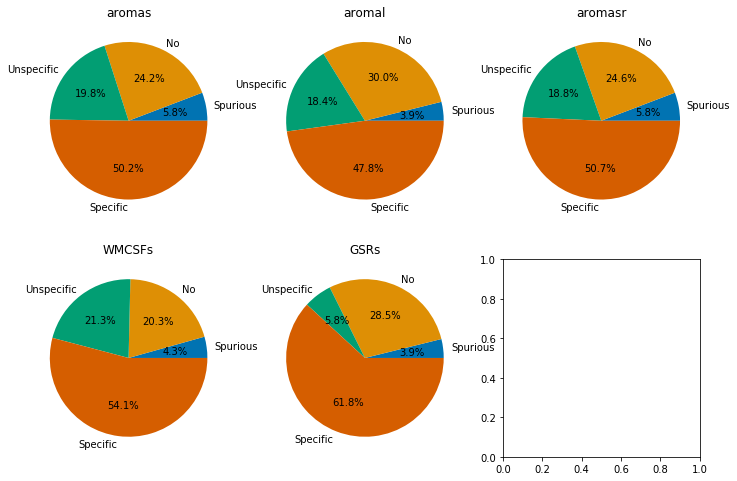

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

sns.set_palette("colorblind")

ax1 = df_exclude['aromas_S1bf_cat'].value_counts(sort=False).plot.pie(title='aromas',ax=axes[0,0], autopct="%.1f%%")
ax2 = df_exclude['aromal_S1bf_cat'].value_counts(sort=False).plot.pie(title='aromal',ax=axes[0,1],autopct="%.1f%%")    
ax3 = df_exclude['aromasr_S1bf_cat'].value_counts(sort=False).plot.pie(title='aromasr',ax=axes[0,2],autopct="%.1f%%")    
ax4 = df_exclude['WMCSFs_S1bf_cat'].value_counts(sort=False).plot.pie(title='WMCSFs',ax=axes[1,0],autopct="%.1f%%")    
ax5 = df_exclude['GSRs_S1bf_cat'].value_counts(sort=False).plot.pie(title='GSRs',ax=axes[1,1],autopct="%.1f%%")    


ax1.set(xlabel="", ylabel="")
ax2.set(xlabel="", ylabel="")
ax3.set(xlabel="", ylabel="")
ax4.set(xlabel="", ylabel="")
ax5.set(xlabel="", ylabel="")


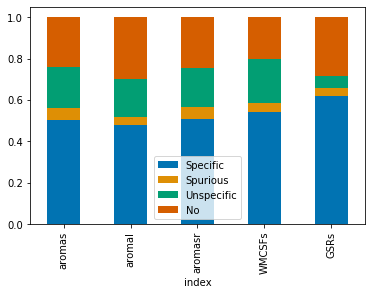

In [20]:
specificity_denoise= pd.concat([df_exclude['aromas_S1bf_cat'].value_counts(sort=False),
                                df_exclude['aromal_S1bf_cat'].value_counts(sort=False),
                                df_exclude['aromasr_S1bf_cat'].value_counts(sort=False),
                                df_exclude['WMCSFs_S1bf_cat'].value_counts(sort=False),
                                df_exclude['GSRs_S1bf_cat'].value_counts(sort=False)], axis=1)

specificity_denoise = specificity_denoise/specificity_denoise.sum()
specificity_denoise = specificity_denoise.rename(columns={"aromas_S1bf_cat": "aromas", "aromal_S1bf_cat": "aromal", "aromasr_S1bf_cat": "aromasr", "WMCSFs_S1bf_cat": "WMCSFs", "GSRs_S1bf_cat": "GSRs"})

specificity_denoise_T = specificity_denoise.T
specificity_denoise_T.reset_index(level=0, inplace=True) 
specificity_denoise_T = specificity_denoise_T[["index","Specific", "Spurious", "Unspecific","No"]]

specificity_denoise_T.set_index('index').plot(kind='bar', stacked=True)

#plt.savefig(os.path.join(init_folder,'assets','figure','Figure2C.svg'), format="svg", dpi=600)
plt.show()

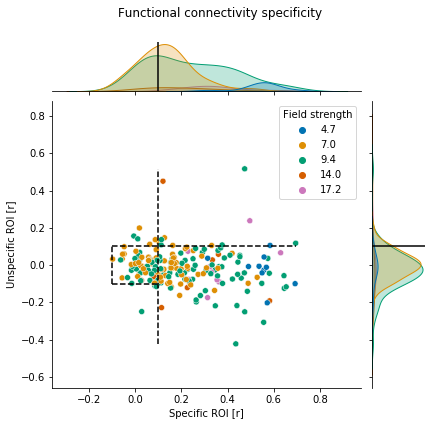

In [21]:
ax6 = sns.jointplot(data=df_exclude, x='GSRs_S1bf_S1bf', y='GSRs_S1bf_ACA', hue='Field_strength')
#ax6.plot_joint(sns.kdeplot,linestyles='dashed', zorder=0, levels=6)

sns.set_palette("colorblind")

ax6.fig.suptitle('Functional connectivity specificity')
ax6.fig.subplots_adjust(top=0.9)
ax6.ax_joint.set(xlabel='Specific ROI [r]', ylabel='Unspecific ROI [r]')
ax6.ax_joint.get_legend().set_title('Field strength')
ax6.ax_joint.vlines(0.1,ymin=min(df_exclude['GSRs_S1bf_ACA']),ymax=max(df_exclude['GSRs_S1bf_ACA']),linestyles='dashed', color='black')
ax6.ax_joint.vlines(-0.1, -0.1,0.1,linestyles='dashed', color='black')
ax6.ax_joint.hlines(-0.1, -0.1,0.1,linestyles='dashed', color='black')
ax6.ax_joint.hlines(0.1, -0.1,xmax=max(df_exclude['GSRs_S1bf_S1bf']),linestyles='dashed', color='black')
ax6.ax_marg_x.axvline(x=0.1, color='black')
ax6.ax_marg_y.axhline(y=0.1, color='black')

## Now doing a Chi2 test to see distribution of specificity among variables

From preregistration: 
"Specificity: parameter associated with connectivity specificity. 
Assuming S1 and Cg belong to distinct anti- (or minimally-) correlated networks, FC specificity will be determined the 4 quadrant system in Grandjean et al 2020. A ??2 test will be used to determine which factors (field strength, coil design, anesthesia, strain, gender) have a skewed distribution of specific FC. "

In [22]:
from scipy.stats import chi2_contingency
from math import sqrt

# now testing strain
chi_stack = df_exclude.groupby(['Strain', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Strain effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing sex
chi_stack = df_exclude.groupby(['Sex', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Sex effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing field strength
chi_stack = df_exclude.groupby(['Field_strength', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Field strength effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))



GSRs_S1bf_cat    No  Specific  Spurious  Unspecific    sum  Specific_percent
Strain                                                                      
Long Evans      0.0      10.0       0.0         0.0   10.0              1.00
Wistar         55.0     114.0       7.0        11.0  187.0              0.61
F344            4.0       4.0       1.0         1.0   10.0              0.40
Strain effect: g-value = 8.772222253693466 dof = 6 p-value = 0.18679916664207527 Phi = 0.145

GSRs_S1bf_cat  No  Specific  Spurious  Unspecific  sum  Specific_percent
Sex                                                                     
Male           28        75         4           7  114              0.66
Female         31        53         4           5   93              0.57
Sex effect: g-value = 2.158910332616328 dof = 3 p-value = 0.5400870330866645 Phi = 0.072

GSRs_S1bf_cat   No  Specific  Spurious  Unspecific  sum  Specific_percent
Field_strength                                                  

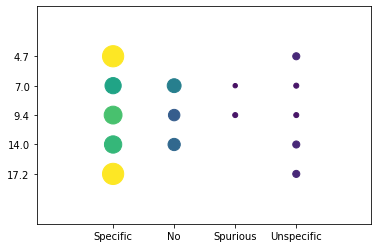

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#adapted from https://stackoverflow.com/questions/50399802/python-categorical-bubble-plot and https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby

dfu = df_exclude.groupby(['Field_strength', 
                    'GSRs_S1bf_cat']).size()
                    

dfu_pcts = dfu.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).to_frame().reset_index().rename(columns={0: "percent",  'GSRs_S1bf_cat': "category"})
dfu_pcts['category']=pd.Categorical(dfu_pcts['category'], categories=["Specific", "No", "Spurious","Unspecific"], ordered=False)
dfu_pcts['Field_strength'] = dfu_pcts['Field_strength'].astype(str)
dfu_pcts['Field_strength'] = pd.Categorical(dfu_pcts['Field_strength'], categories=["17.2", "14.0", "11.7","9.4","7.0","4.7","3.0"])

dfu_pcts= dfu_pcts.sort_values(by=['Field_strength','category'], ascending=True)
dfu_pcts['percent'] *= 5

plt.scatter(x="category", y='Field_strength', s="percent", c='percent', marker='o',data=dfu_pcts)
plt.margins(0.4)
plt.show()

In [24]:
# now testing anesthesia.breathing.rate
df_exclude['breathing_bin']=pd.cut(df_exclude['Breathing_onset'],6)
chi_stack = df_exclude.groupby(['breathing_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Breathing rate effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))


# now testing Mean framewise displacement
df_exclude['MFW_bin']=pd.cut(df_exclude['MFW'],6)
chi_stack = df_exclude.groupby(['MFW_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Mean framewise displacement effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing Max framewise displacement
df_exclude['maxFW_bin']=pd.cut(df_exclude['maxFW'],6)
chi_stack = df_exclude.groupby(['maxFW_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Max framewise displacement effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing tSNR in S1
df_exclude['tsnr_bin']=pd.cut(df_exclude['tsnr.S1'],6)
chi_stack = df_exclude.groupby(['tsnr_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('tSNR effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))


# now testing temperature
df_exclude['Temperature_bin']=pd.cut(df_exclude['Temperature_onset'],6)
chi_stack = df_exclude.groupby(['Temperature_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Temperature effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))



GSRs_S1bf_cat     No  Specific  Spurious  Unspecific  sum  Specific_percent
breathing_bin                                                              
(99.167, 114.0]    0         4         0           0    4              1.00
(84.333, 99.167]   0         3         1           0    4              0.75
(69.5, 84.333]    10        20         0           1   31              0.65
(54.667, 69.5]    17        37         3           3   60              0.62
(39.833, 54.667]  23        44         4           5   76              0.58
(24.911, 39.833]   8        12         0           3   23              0.52
Breathing rate effect: g-value = 14.330660382881563 dof = 15 p-value = 0.5006133297653074 Phi = 0.189

GSRs_S1bf_cat     No  Specific  Spurious  Unspecific  sum  Specific_percent
MFW_bin                                                                    
(0.0327, 0.039]    0         4         0           0    4              1.00
(0.039, 0.0452]    0         1         0           0    1   

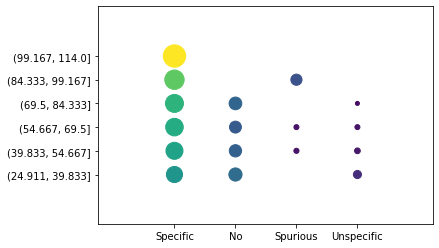

In [25]:

#adapted from https://stackoverflow.com/questions/50399802/python-categorical-bubble-plot and https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
df_exclude['breathing_bin']=pd.cut(df_exclude['Breathing_onset'],6)
dfu = df_exclude.groupby(['breathing_bin', 
                    'GSRs_S1bf_cat']).size()
                    

dfu_pcts = dfu.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).to_frame().reset_index().rename(columns={0: "percent",  'GSRs_S1bf_cat': "category"})
dfu_pcts['category']=pd.Categorical(dfu_pcts['category'], categories=["Specific", "No", "Spurious","Unspecific"], ordered=False)
dfu_pcts['breathing_bin'] = dfu_pcts['breathing_bin'].astype(str)
dfu_pcts['breathing_bin'] = pd.Categorical(dfu_pcts['breathing_bin'])

dfu_pcts= dfu_pcts.sort_values(by=['category','percent'], ascending=True)
dfu_pcts['percent'] *= 5

plt.scatter(x="category", y='breathing_bin', s="percent", c='percent', marker='o',data=dfu_pcts)
plt.margins(0.4)
plt.show()


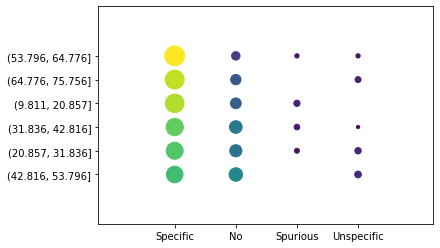

In [26]:
#adapted from https://stackoverflow.com/questions/50399802/python-categorical-bubble-plot and https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
df_exclude['tsnr_bin']=pd.cut(df_exclude['tsnr.S1'],6)
dfu = df_exclude.groupby(['tsnr_bin', 
                    'GSRs_S1bf_cat']).size()
                    

dfu_pcts = dfu.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).to_frame().reset_index().rename(columns={0: "percent",  'GSRs_S1bf_cat': "category"})
dfu_pcts['category']=pd.Categorical(dfu_pcts['category'], categories=["Specific", "No", "Spurious","Unspecific"], ordered=False)
dfu_pcts['tsnr_bin'] = dfu_pcts['tsnr_bin'].astype(str)
dfu_pcts['tsnr_bin'] = pd.Categorical(dfu_pcts['tsnr_bin'])

dfu_pcts= dfu_pcts.sort_values(by=['category','percent'], ascending=True)
dfu_pcts['percent'] *= 5

plt.scatter(x="category", y='tsnr_bin', s="percent", c='percent', marker='o',data=dfu_pcts)
plt.margins(0.4)
plt.show()


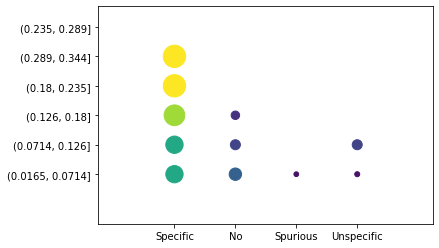

In [27]:
#adapted from https://stackoverflow.com/questions/50399802/python-categorical-bubble-plot and https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
df_exclude['maxFW_bin']=pd.cut(df_exclude['maxFW'],6)
dfu = df_exclude.groupby(['maxFW_bin', 
                    'GSRs_S1bf_cat']).size()
                    

dfu_pcts = dfu.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).to_frame().reset_index().rename(columns={0: "percent",  'GSRs_S1bf_cat': "category"})
dfu_pcts['category']=pd.Categorical(dfu_pcts['category'], categories=["Specific", "No", "Spurious","Unspecific"], ordered=False)
dfu_pcts['maxFW_bin'] = dfu_pcts['maxFW_bin'].astype(str)
dfu_pcts['maxFW_bin'] = pd.Categorical(dfu_pcts['maxFW_bin'])

dfu_pcts= dfu_pcts.sort_values(by=['category','percent'], ascending=True)
dfu_pcts['percent'] *= 5

plt.scatter(x="category", y='maxFW_bin', s="percent", c='percent', marker='o',data=dfu_pcts)
plt.margins(0.4)
plt.show()

In [28]:
# check how datasets are prefroming
chi_stack = df_exclude.groupby(['DatasetID', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.fillna(0)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)

print("FC specificity distribution per dataset, WMCSFs denoising")
print(chi_stack["Specific_percent"].quantile([0.25,0.5,0.75]))
chi_stack.sort_values(by="Specific_percent",ascending=False)


FC specificity distribution per dataset, WMCSFs denoising
0.25    0.40
0.50    0.60
0.75    0.89
Name: Specific_percent, dtype: float64


GSRs_S1bf_cat,No,Specific,Spurious,Unspecific,sum,Specific_percent
DatasetID,,,,,,
3001,0.0,10.0,0.0,0.0,10.0,1.00
3011,0.0,10.0,0.0,0.0,10.0,1.00
3012,0.0,9.0,0.0,1.0,10.0,0.90
3005,0.0,9.0,0.0,1.0,10.0,0.90
3009,0.0,9.0,1.0,0.0,10.0,0.90
3008,1.0,8.0,0.0,0.0,9.0,0.89
3010,0.0,8.0,0.0,2.0,10.0,0.80
3016,1.0,8.0,0.0,1.0,10.0,0.80
3007,3.0,7.0,0.0,0.0,10.0,0.70


## Now looking at FC sensitivity

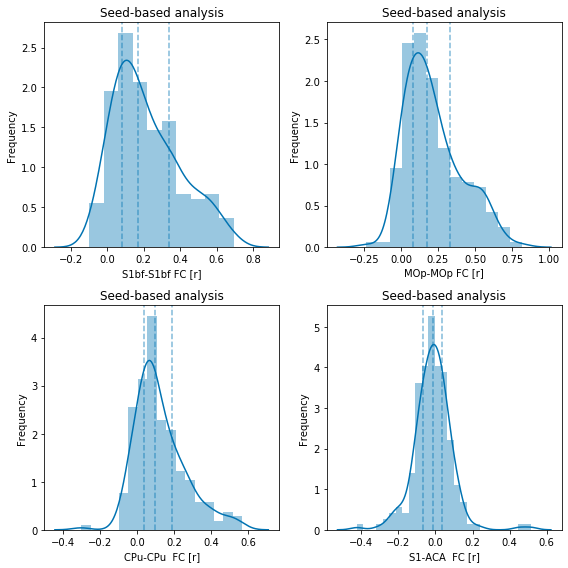

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
sns.set_palette("colorblind")

ax1 = sns.distplot(df_exclude['GSRs_S1bf_S1bf'],ax=axes[0,0])
ax2 = sns.distplot(df_exclude['GSRs_MOp_MOp'],ax=axes[0,1])
ax3 = sns.distplot(df_exclude['GSRs_CPu_CPu'],ax=axes[1,0])
ax4 = sns.distplot(df_exclude['GSRs_S1bf_ACA'],ax=axes[1,1])

ax1.set(xlabel='S1bf-S1bf FC [r]', ylabel='Frequency', title='Seed-based analysis')
ax2.set(xlabel='MOp-MOp FC [r]', ylabel='Frequency', title='Seed-based analysis')
ax3.set(xlabel='CPu-CPu  FC [r]', ylabel='Frequency', title='Seed-based analysis')
ax4.set(xlabel='S1-ACA  FC [r]', ylabel='Frequency', title='Seed-based analysis')

ax1.axvline(df_exclude['GSRs_S1bf_S1bf'].quantile(0.25),ls='--',alpha=0.5)
ax1.axvline(df_exclude['GSRs_S1bf_S1bf'].quantile(0.50),ls='--',alpha=0.5)
ax1.axvline(df_exclude['GSRs_S1bf_S1bf'].quantile(0.75),ls='--',alpha=0.5)

ax2.axvline(df_exclude['GSRs_MOp_MOp'].quantile(0.25),ls='--',alpha=0.5)
ax2.axvline(df_exclude['GSRs_MOp_MOp'].quantile(0.50),ls='--',alpha=0.5)
ax2.axvline(df_exclude['GSRs_MOp_MOp'].quantile(0.75),ls='--',alpha=0.5)


ax3.axvline(df_exclude['GSRs_CPu_CPu'].quantile(0.25),ls='--',alpha=0.5)
ax3.axvline(df_exclude['GSRs_CPu_CPu'].quantile(0.50),ls='--',alpha=0.5)
ax3.axvline(df_exclude['GSRs_CPu_CPu'].quantile(0.75),ls='--',alpha=0.5)

ax4.axvline(df_exclude['GSRs_S1bf_ACA'].quantile(0.25),ls='--',alpha=0.5)
ax4.axvline(df_exclude['GSRs_S1bf_ACA'].quantile(0.50),ls='--',alpha=0.5)
ax4.axvline(df_exclude['GSRs_S1bf_ACA'].quantile(0.75),ls='--',alpha=0.5)


plt.tight_layout()

In [30]:
#extracting quartiles for the functional connectivity parameters
df_exclude[['GSRs_S1bf_S1bf','GSRs_MOp_MOp','GSRs_CPu_CPu','GSRs_S1bf_ACA']].quantile([0.25,0.5,0.75])

,GSRs_S1bf_S1bf,GSRs_MOp_MOp,GSRs_CPu_CPu,GSRs_S1bf_ACA
0.25,0.081646,0.078938,0.036880,-0.069262
0.50,0.168683,0.173699,0.094894,-0.015232
0.75,0.338559,0.329100,0.188954,0.037439


[Text(0, 0.5, 'FC [r]'), Text(0.5, 0, 'Mean framewise displacement')]

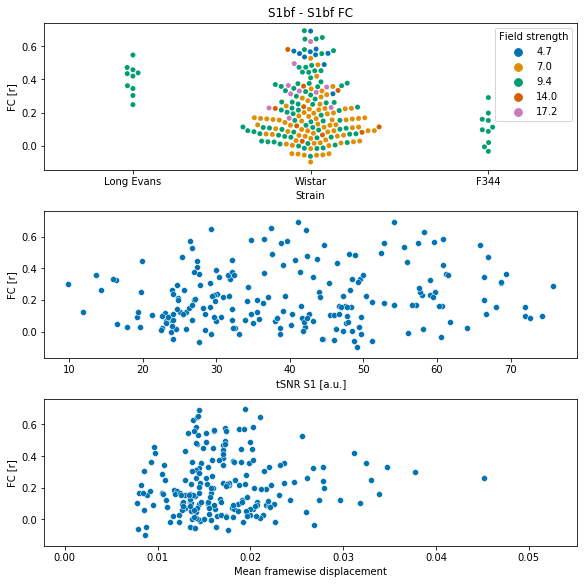

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
#plotting as a function of different parameters

fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8, 8),constrained_layout=True)


sns.set_palette("colorblind")
df_exclude = df.loc[(df['exclude'] != 'yes')]

ax0 = sns.swarmplot(data=df_exclude, x="Strain",
                    y="GSRs_S1bf_S1bf", hue="Field_strength",ax=axes[0])
ax1 = sns.scatterplot(data=df_exclude, x="tsnr.S1",
                    y="GSRs_S1bf_S1bf",ax=axes[1])

ax2 = sns.scatterplot(data=df_exclude, x="MFW",
                    y="GSRs_S1bf_S1bf",ax=axes[2])


ax0.set(xlabel='Strain', ylabel='FC [r]', title='S1bf - S1bf FC')
ax0.get_legend().set_title('Field strength')

ax1.set(xlabel='tSNR S1 [a.u.]', ylabel='FC [r]')

ax2.set(xlabel='Mean framewise displacement', ylabel='FC [r]')

#plt.constrained_layout()


## Group analysis. Estimating one sample t-test maps per datasets (session 1 exclusively). 
Images are exported as z-score image, thresholded z > 1.9 corresponding to p =< 0.05, one tailed, uncorrected (a very liberal threshold!) 

From preregistration: 
"Seed-based analysis voxel-wise analysis across the individual datasets
The seed-based analysis from the individual datasets (each consisting of n=10) will be examined with a more lenient parametric one-sample t-test (fsl_glm), without cluster correction and p-value threshold 0.05. This is to ensure that no FC is rejected (low false negative), but at the expense of a higher false-positive rate. The analysis across individual datasets will be summarized in an overlap map denoting the percentage of datasets reaching significance for each voxel. "


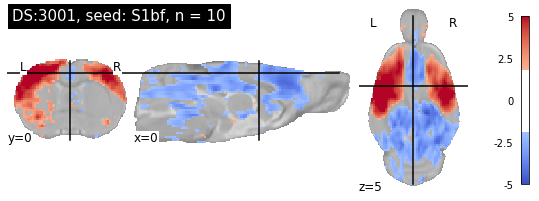

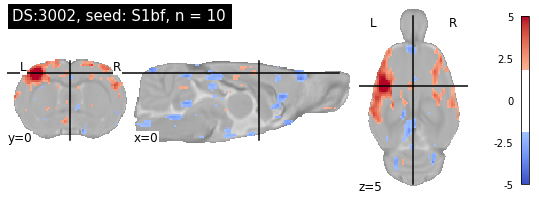

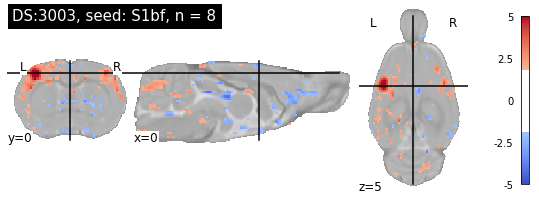

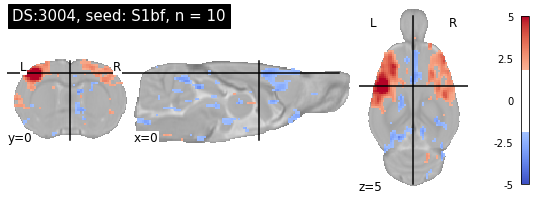

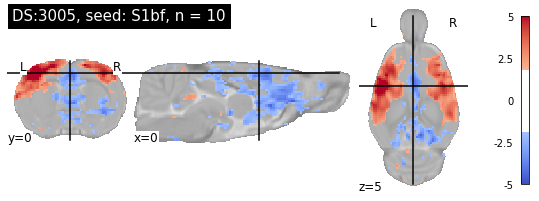

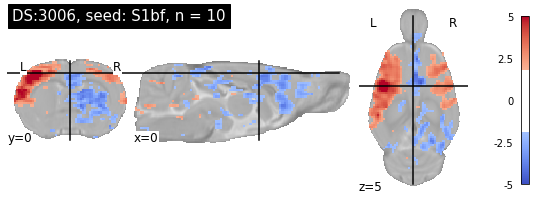

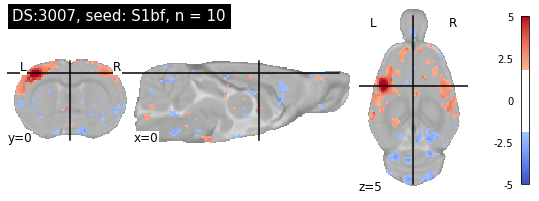

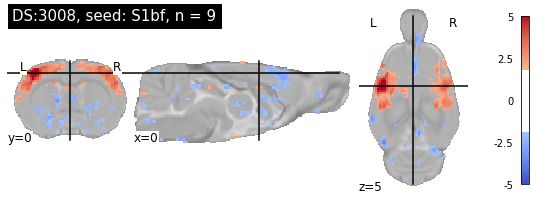

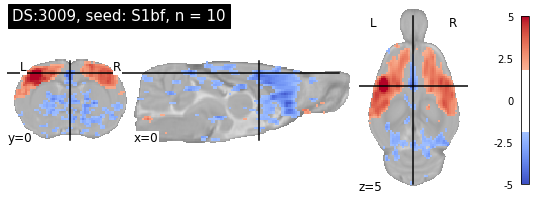

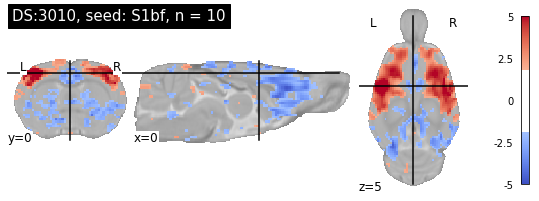

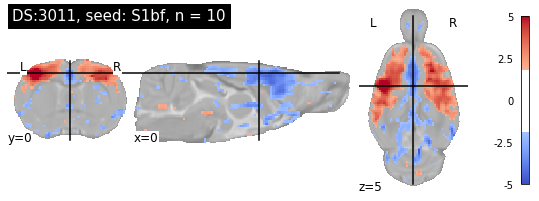

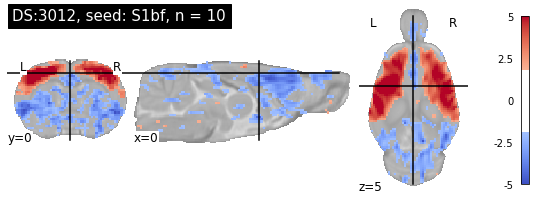

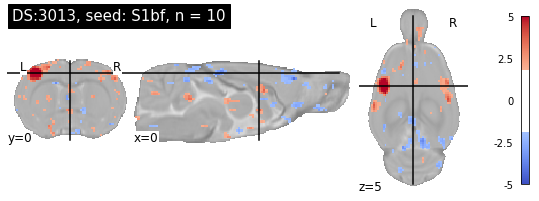

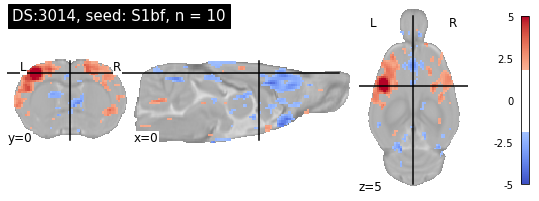

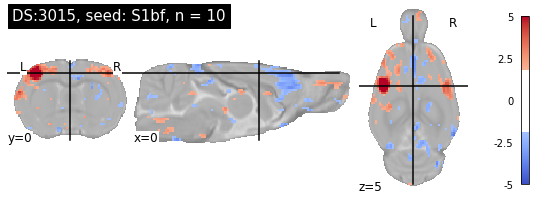

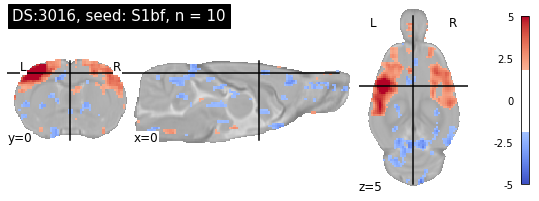

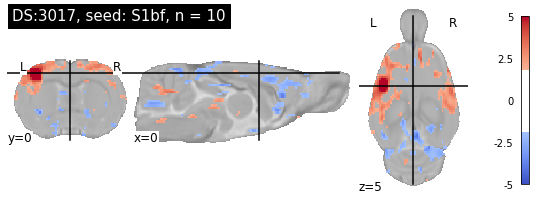

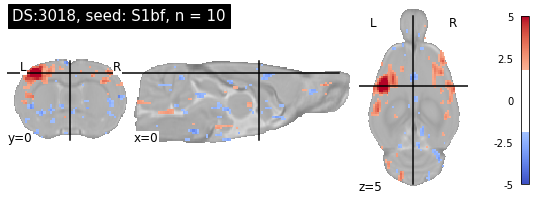

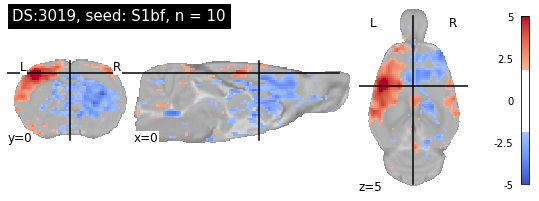

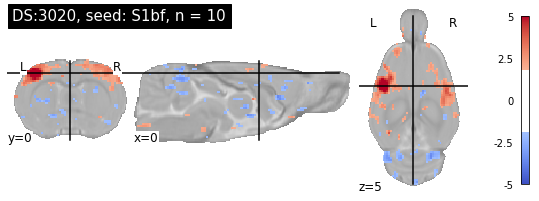

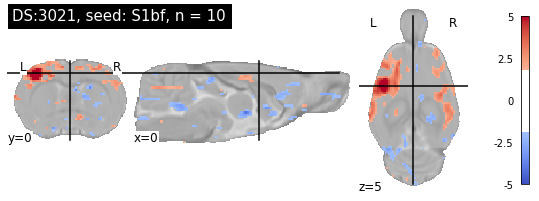

In [32]:
import re
from nilearn.image import concat_imgs, threshold_img,math_img, resample_img
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
import pandas as pd


bg_img = os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Template_Masked.nii')
maskimg = os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Mask.nii')

# output folders
output_nii = os.path.join(analysis_folder, 'export_std', 'group_SBA')
output_img = os.path.join(analysis_folder, 'export_std', 'group_SBA_img')
os.makedirs(output_nii, exist_ok=True)
os.makedirs(output_img, exist_ok=True)

# re-read the table
df_exclude = df.loc[(df['exclude'] != 'yes')]

# re-read all seed files in the path.
condtion = 'GSRs'
seed_list = glob.glob(
    (os.path.join(analysis_folder, 'export_std', 'seed', condtion))+'/*')
seed_group = ['S1bf','ACA', 'CPu','MOp']
y_stack = [0.14, 2.2, 1.6, 3.1]

for i in list(df_exclude['DatasetID'].unique()):
    for count, seed in enumerate(seed_group):

        r = re.compile(seed)
        seed_list_sub = list(filter(r.findall, seed_list))
        r = re.compile(str(i))
        seed_list_sub = list(filter(r.findall, seed_list_sub))
        r = re.compile("(" + ")|(".join(df_exclude['SubjID'].loc[df_exclude['DatasetID'] == i]) + ")")
        seed_list_sub = list(filter(r.findall, seed_list_sub))
        
        maskimg_rs = resample_img(maskimg,interpolation='nearest', target_shape=(64, 109, 64), 
                        target_affine=np.array([[0.30000001,0.,-0., -9.43999958],
                        [0.,0.30000001,-0.,-17.80999947],
                        [0.,0.,0.30000001,-6.76499987],
                        [0.,0.,0.,1.]]))
        
        for count_seedlist, seed_indiv in enumerate(seed_list_sub):
            seed_indiv_rs = resample_img(seed_indiv, target_shape=(64, 109, 64), 
                        target_affine=np.array([[0.30000001,0.,-0., -9.43999958],
                        [0.,0.30000001,-0.,-17.80999947],
                        [0.,0.,0.30000001,-6.76499987],
                        [0.,0.,0.,1.]]))
            seed_indiv_rs.to_filename(seed_indiv)
    
        second_level_input = seed_list_sub
        design_matrix = pd.DataFrame([1] * len(seed_list_sub), columns=['intercept'])
        
        second_level_model = SecondLevelModel(mask_img=maskimg_rs) 
        
        second_level_model = second_level_model.fit(second_level_input,design_matrix=design_matrix)

        z_map = second_level_model.compute_contrast(output_type='z_score')
        
        filename_export = 'DS-'+str(i)+"_seed-"+seed
        filename_path = os.path.join(analysis_folder, 'export_std', output_nii, filename_export)

        z_map.to_filename(filename_path+'.nii.gz')

        filename_path = os.path.join(analysis_folder, 'export_std', output_img, filename_export)
        plot_stat_map(z_map, bg_img, title='DS:' + str(i) +', seed: ' + seed + ', n = '+ str(len(seed_list_sub)), threshold=1.9, vmax=5, symmetric_cbar=True, cmap='coolwarm', black_bg=False,cut_coords=(0, y_stack[count], 5),output_file=filename_path+'.svg')
        #remake plot with output to jupyter notebook if S1bf seed
        if(seed == 'S1bf'):
            plot_stat_map(z_map, bg_img,title='DS:' + str(i) + ', seed: ' + seed + ', n = '+ str(len(seed_list_sub)), threshold=1.9, vmax=5, symmetric_cbar=True, cmap='coolwarm',  black_bg=False, cut_coords=(0, y_stack[count], 5))

## Estimate incidence maps
Load one-sample t-test, threshold and perform mean across 4th dimension. 


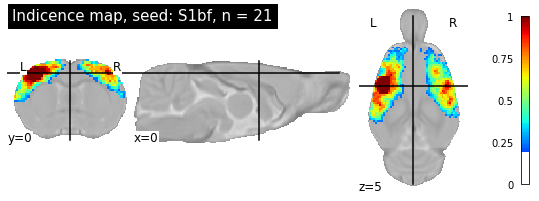

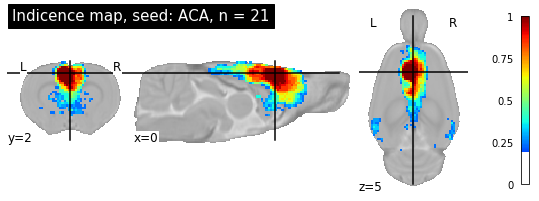

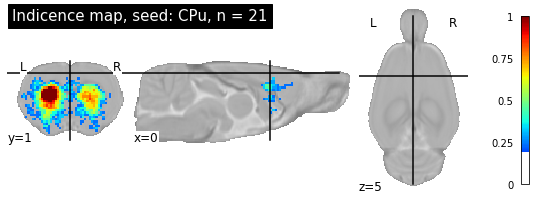

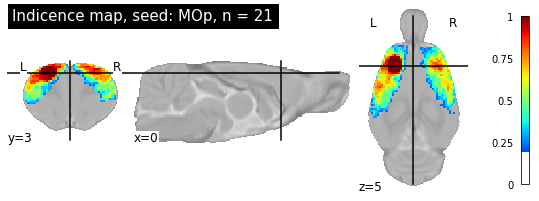

In [33]:
import re
from nilearn.image import concat_imgs, threshold_img,math_img
from nilearn.plotting import plot_stat_map
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# combine jet colormap for plot_stat_map (see https://stackoverflow.com/a/31052741)
# select to color scheme to use
colors1 = plt.cm.jet(np.linspace(0., 1, 128))
colors = np.vstack((colors1, colors1))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


bg_img = os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Template_Masked.nii')

# output folders
output_incidence = os.path.join(analysis_folder, 'export_std', 'group_SBA_incidence')
os.makedirs(output_incidence, exist_ok=True)

# read all one sample t-test files in the path.
seed_list = glob.glob(
    (os.path.join(analysis_folder, 'export_std', 'group_SBA'))+'/*')
seed_group = ['S1bf','ACA', 'CPu','MOp']
y_stack = [0.14, 2.2, 1.6, 3.1]

for count,seed in enumerate(seed_group):

    filename_export = "seed-"+seed
    filename_path = os.path.join(analysis_folder, 'export_std', output_incidence, filename_export)

    r = re.compile(seed)
    seed_list_sub = list(filter(r.findall, seed_list))

    con_img = concat_imgs(seed_list_sub, auto_resample=True)
    th_img = math_img("img >=  1.9", img=con_img)
    ma_img = math_img("np.mean(img, axis=-1)", img=th_img)
    ma_img.to_filename(filename_path+'.nii.gz')

    #one for the save
    plot_stat_map(ma_img,
              bg_img,
              title='Indicence map, seed: ' + seed + ', n = '+ str(len(seed_list_sub)),
              threshold=0.2,
             vmax=1,
              symmetric_cbar=False,
              cmap=mymap,
              black_bg=False,
              # display_mode="y",
              cut_coords=(0, y_stack[count], 5))

    #one for jupyter export..    teeeeedious
    plot_stat_map(ma_img,
              bg_img,
              title='Indicence map, seed: ' + seed + ', n = '+ str(len(seed_list_sub)),
              threshold=0.2,
             vmax=1,
              symmetric_cbar=False,
              cmap=mymap,
              black_bg=False,
              # display_mode="y",
              cut_coords=(0,  y_stack[count], 5),
              output_file=filename_path+'.svg')

In [38]:
import re
from nilearn.image import resample_to_img
import pandas as pd
import glob
import os


scan_list = glob.glob((os.path.join(analysis_folder, 'export_std', 'GSRs'))+'/*')


In [39]:
for count_seedlist, scam_indiv in enumerate(scan_list):
            scan_indiv_rs = resample_to_img(scam_indiv,scan_list[0])
            scan_indiv_rs.to_filename(scam_indiv)

MemoryError: 

In [5]:
r = re.compile("(" + ")|(".join(df_exclude['SubjID'].loc[df_exclude['GSRs_S1bf_cat'] == 'Specific']) + ")")
scan_list_sub = list(filter(r.findall, scan_list))
np.savetxt('../assets/tmp/melodic_scanlist.txt',scan_list_sub,delimiter="\n", fmt="%s")

In [18]:
from nilearn.decomposition import CanICA

location_cache = '/project/4180000.19/nilearn_cache'
! mkdir -p location_cache


canica = CanICA(n_components=20,
                memory = location_cache, memory_level=30,
                verbose=10,
                smoothing_fwhm=None,
                mask='../assets/tmp/rs_mask.nii.gz',
                random_state=0)
canica.fit(scan_list_sub)

canica_components_img = canica.components_img_
canica_components_img.to_filename('../assets/nifti/canica_resting_state.nii.gz')

[MultiNiftiMasker.fit] Loading data from None
[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/project/4180000.19/multiRat/export_std/GSRs/sub-300801_task-rest_bold_combined_cleaned.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/project/4180000.19/multiRat/export_std/GSRs/sub-300807_task-rest_bold_combined_cleaned.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/project/4180000.19/multiRat/export_std/GSRs/sub-301205_task-rest_bold_RAS_combined_cleaned.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs

[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/project/4180000.19/multiRat/export_std/GSRs/sub-300605_task-rest_bold_combined_cleaned.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/project/4180000.19/multiRat/export_std/GSRs/sub-301101_task-rest_bold_RAS_combined_cleaned.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/project/4180000.19/multiRat/export_std/GSRs/sub-300502_task-rest_bold_RAS_combined_cleaned.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiM

[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/project/4180000.19/multiRat/export_std/GSRs/sub-300906_task-rest_bold_RAS_combined_cleaned.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/project/4180000.19/multiRat/export_std/GSRs/sub-300103_task-rest_bold_RAS_combined_cleaned.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/project/4180000.19/multiRat/export_std/GSRs/sub-301009_task-rest_bold_RAS_combined_cleaned.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNi

[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/project/4180000.19/multiRat/export_std/GSRs/sub-300602_task-rest_bold_combined_cleaned.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/project/4180000.19/multiRat/export_std/GSRs/sub-300806_task-rest_bold_combined_cleaned.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/project/4180000.19/multiRat/export_std/GSRs/sub-300707_task-rest_bold_RAS_combined_cleaned.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMaske

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[-0.000158, ...,  0.00377 ],
       ...,
       [-0.001708, ...,  0.001531]]), whiten=True, fun='cube', random_state=209652396)
__________________________________________________________fastica - 4.6s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[-0.000158, ...,  0.00377 ],
       ...,
       [-0.001708, ...,  0.001531]]), whiten=True, fun='cube', random_state=398764591)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


__________________________________________________________fastica - 5.4s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[-0.000158, ...,  0.00377 ],
       ...,
       [-0.001708, ...,  0.001531]]), whiten=True, fun='cube', random_state=924231285)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s


__________________________________________________________fastica - 4.6s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[-0.000158, ...,  0.00377 ],
       ...,
       [-0.001708, ...,  0.001531]]), whiten=True, fun='cube', random_state=1478610112)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.8s remaining:    0.0s


__________________________________________________________fastica - 4.1s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[-0.000158, ...,  0.00377 ],
       ...,
       [-0.001708, ...,  0.001531]]), whiten=True, fun='cube', random_state=441365315)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.9s remaining:    0.0s


__________________________________________________________fastica - 3.9s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[-0.000158, ...,  0.00377 ],
       ...,
       [-0.001708, ...,  0.001531]]), whiten=True, fun='cube', random_state=1537364731)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.0s remaining:    0.0s


__________________________________________________________fastica - 3.2s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[-0.000158, ...,  0.00377 ],
       ...,
       [-0.001708, ...,  0.001531]]), whiten=True, fun='cube', random_state=192771779)


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   26.3s remaining:    0.0s


__________________________________________________________fastica - 5.3s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[-0.000158, ...,  0.00377 ],
       ...,
       [-0.001708, ...,  0.001531]]), whiten=True, fun='cube', random_state=1491434855)


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   31.7s remaining:    0.0s


__________________________________________________________fastica - 4.4s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[-0.000158, ...,  0.00377 ],
       ...,
       [-0.001708, ...,  0.001531]]), whiten=True, fun='cube', random_state=1819583497)


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   36.1s remaining:    0.0s


__________________________________________________________fastica - 4.7s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[-0.000158, ...,  0.00377 ],
       ...,
       [-0.001708, ...,  0.001531]]), whiten=True, fun='cube', random_state=530702035)


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   40.9s remaining:    0.0s


__________________________________________________________fastica - 5.2s, 0.1min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   46.2s finished


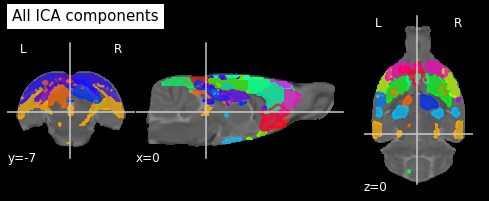

In [19]:
from nilearn.plotting import plot_prob_atlas

bg_img = os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Template_Masked.nii')
# Plot all ICA components together
plot_prob_atlas(canica_components_img,bg_img, title='All ICA components')

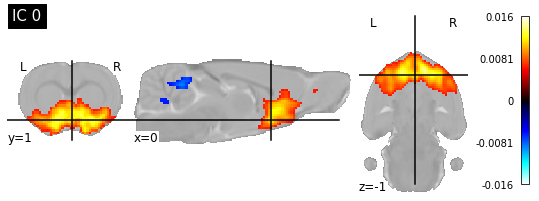

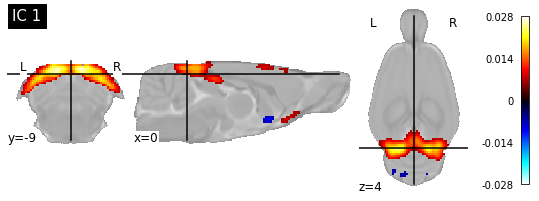

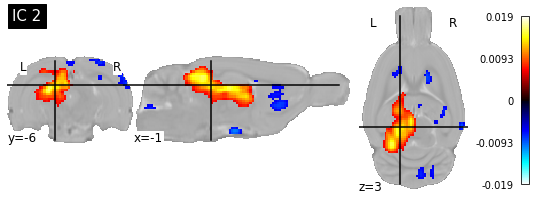

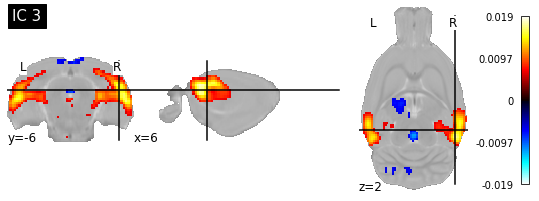

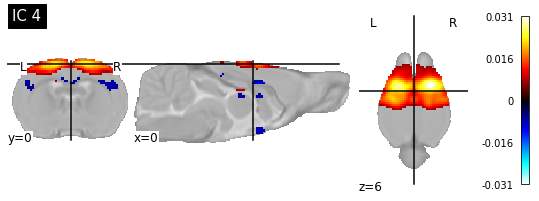

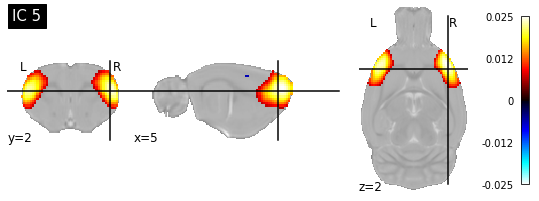

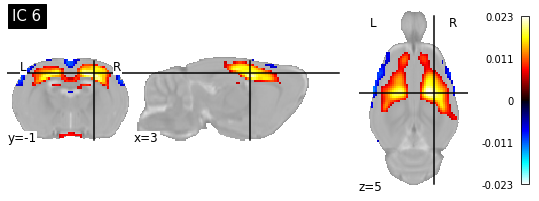

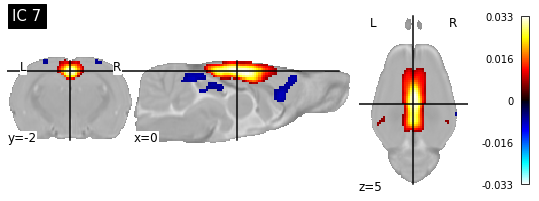

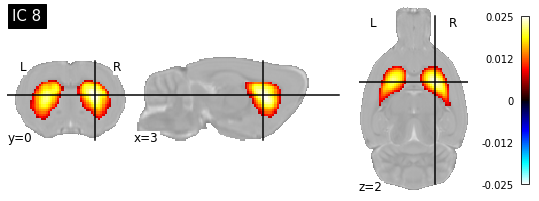

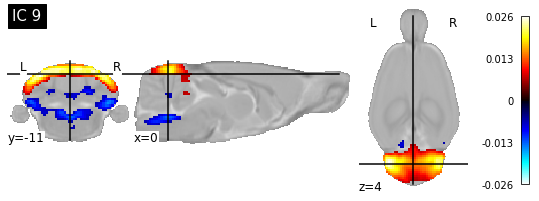

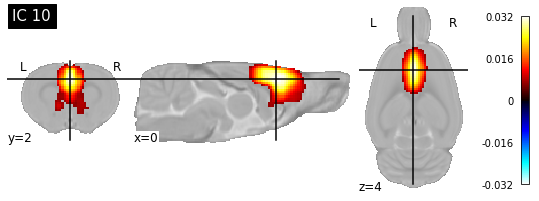

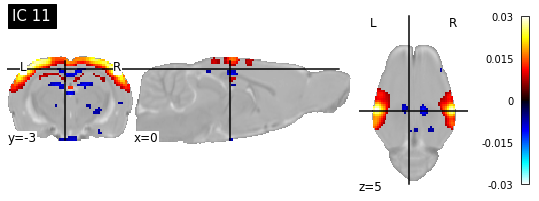

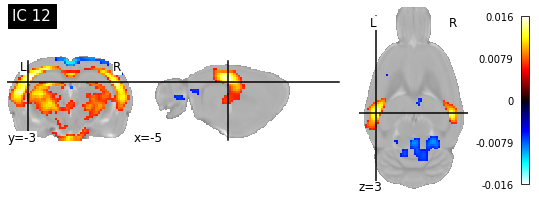

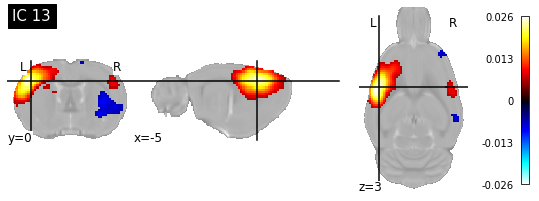

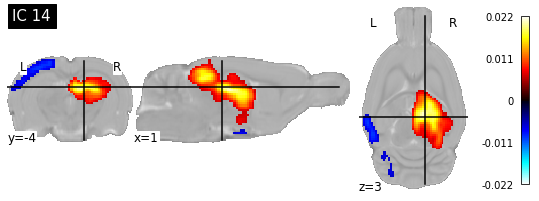

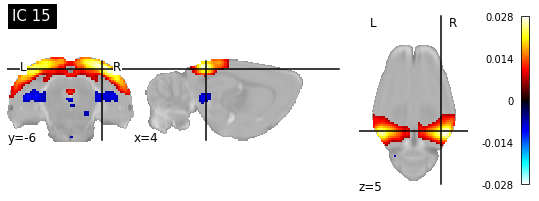

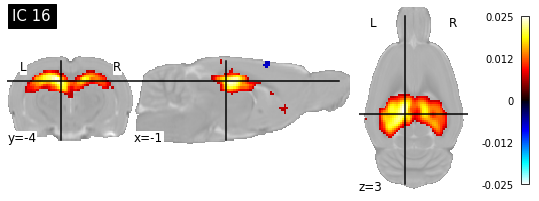

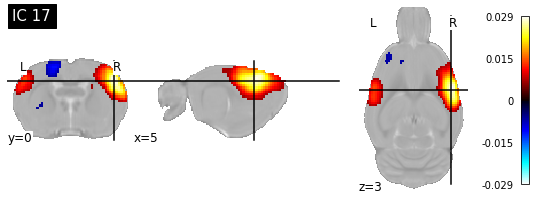

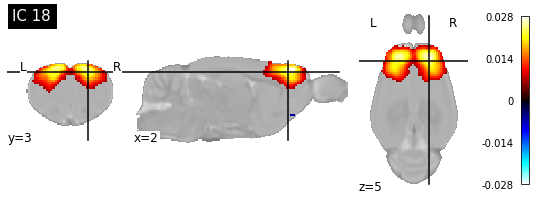

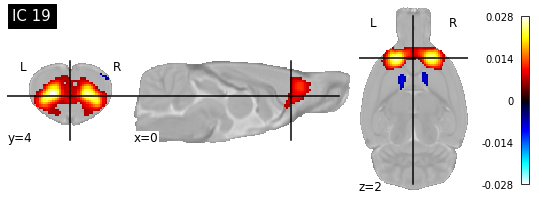

In [22]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(canica_components_img)):
    plot_stat_map(cur_img,bg_img, title="IC %d" % i,
                  black_bg=False,
                  display_mode='ortho', 
                  colorbar=True)

trying the same, but with dictionary learning 
see: https://nilearn.github.io/auto_examples/03_connectivity/plot_compare_decomposition.html#sphx-glr-auto-examples-03-connectivity-plot-compare-decomposition-py

[MultiNiftiMasker.fit] Loading data from None
[MultiNiftiMasker.transform] Resampling mask
[DictLearning] Loading data
[DictLearning] Learning initial components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


[DictLearning] Computing initial loadings
________________________________________________________________________________
[Memory] Calling nilearn.decomposition.dict_learning._compute_loadings...
_compute_loadings(array([[-0.000552, ..., -0.002678],
       ...,
       [ 0.004629, ...,  0.0047  ]]), 
array([[ 4.490594, ..., 12.724794],
       ...,
       [ 2.110836, ...,  2.127253]]))
_________________________________________________compute_loadings - 7.0s, 0.1min
[DictLearning] Learning dictionary
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._dict_learning.dict_learning_online...
dict_learning_online(array([[ 4.490594, ...,  2.110836],
       ...,
       [12.724794, ...,  2.127253]]), 
20, alpha=10, n_iter=4697, batch_size=20, method='cd', dict_init=array([[-0.007867, ...,  0.143077],
       ...,
       [ 0.297317, ..., -0.039031]]), verbose=0, random_state=0, return_code=True, shuffle=True, n_jobs=1)
_________

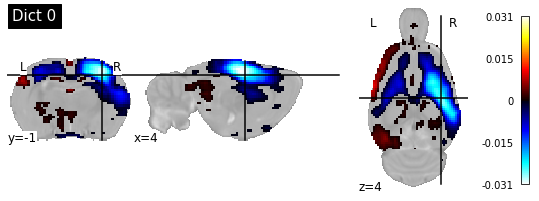

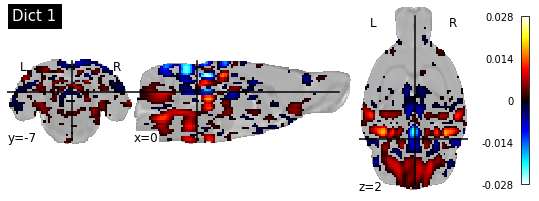

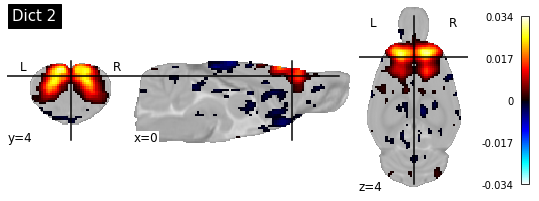

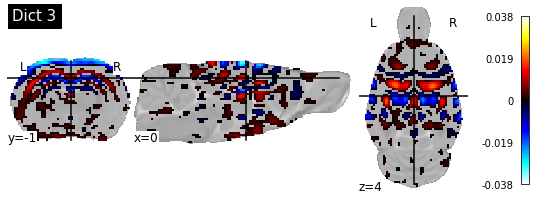

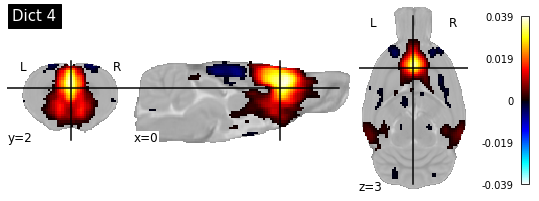

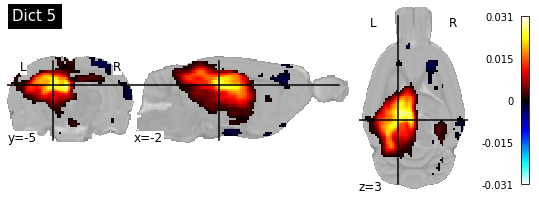

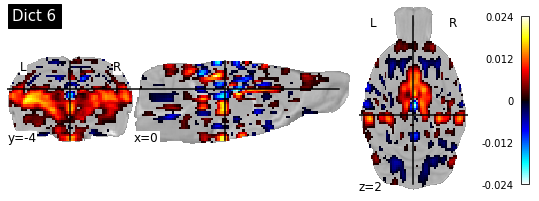

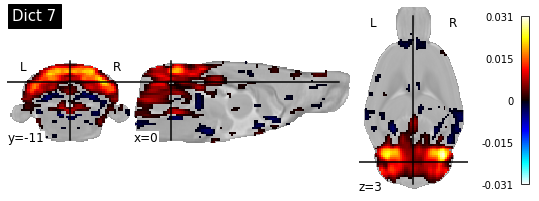

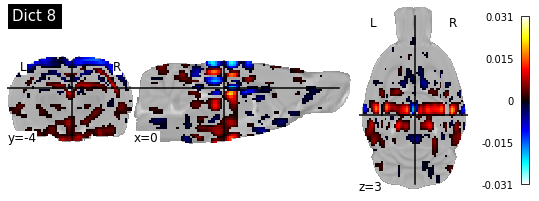

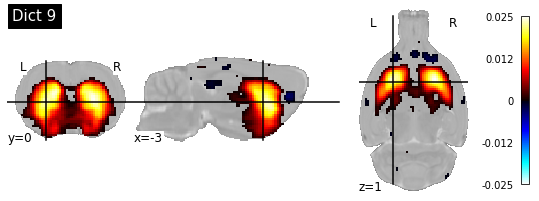

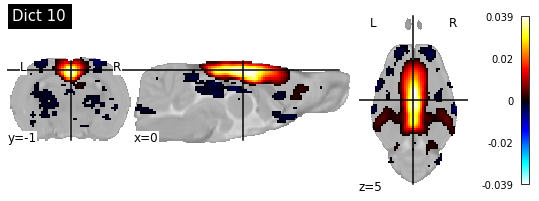

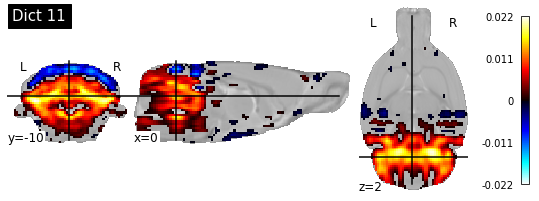

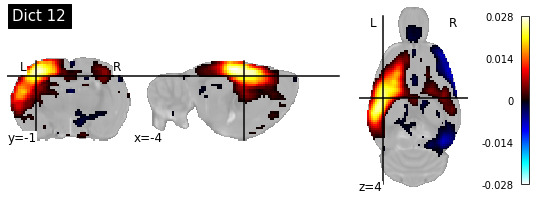

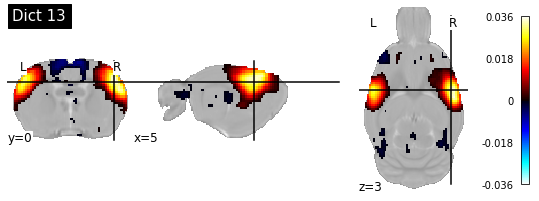

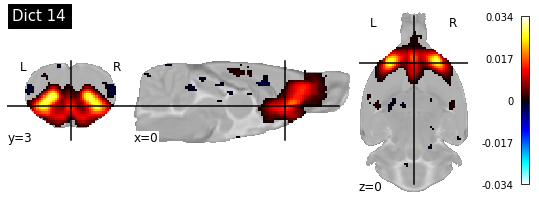

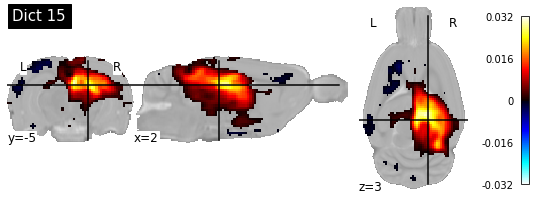

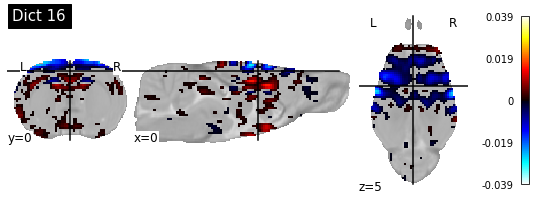

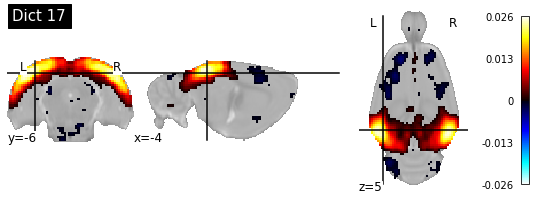

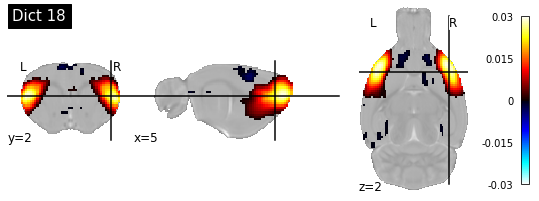

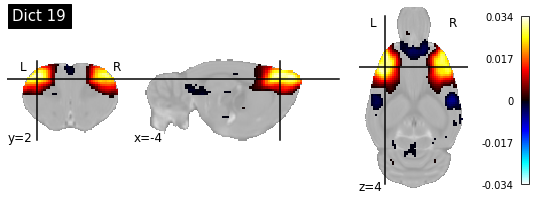

In [24]:
from nilearn.decomposition import DictLearning
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

dict_learning = DictLearning(n_components=20,
                            memory = location_cache, memory_level=30,
                            smoothing_fwhm=None,
                            mask='../assets/tmp/rs_mask.nii.gz',
                             verbose=1,
                             random_state=0,
                             n_epochs=1)

dict_learning.fit(scan_list_sub)

dict_learning_components_img = dict_learning.components_img_
dict_learning_components_img.to_filename('../assets/nifti/dict_resting_state.nii.gz')



for i, cur_img in enumerate(iter_img(dict_learning_components_img)):
    plot_stat_map(cur_img,bg_img, title="Dict %d" % i,
                  black_bg=False,
                  display_mode='ortho', 
                  colorbar=True)